A simple frequency-based pairing heap:

In [1]:
import Data.Semigroup     (Semigroup(..))
import Data.List.NonEmpty (NonEmpty(..))
import Data.Foldable      (foldl')

data Heap a = Heap {-# UNPACK #-} !Int !a [Heap a]

instance Semigroup (Heap a) where
    Heap i x xs <> Heap j y ys
      | i <= j = Heap i x (Heap j y ys : xs)
      | otherwise = Heap j y (Heap i x xs : ys)

minView :: Heap a -> (Int, a, Maybe (Heap a))
minView (Heap i x xs) = (i, x, case xs of
    [] -> Nothing
    (y:ys) -> Just (mergeHeaps y ys))
  where
    mergeHeaps t []          = t
    mergeHeaps t1 [t2]       = t1 <> t2
    mergeHeaps t1 (t2:t3:ts) = (t1 <> t2) <> mergeHeaps t3 ts

insert :: Int -> a -> Heap a -> Heap a
insert i x (Heap j y ys)
  | i <= j = Heap i x [Heap j y ys]
  | otherwise = Heap j y (Heap i x [] : ys)

heapify :: NonEmpty (Int, a) -> Heap a
heapify ((i,x) :| xs) =
    foldl' (flip (uncurry insert)) (Heap i x []) xs

A function to count the frequencies of some elements:

In [2]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

import           Data.Foldable   (Foldable(foldMap,foldl'))

newtype Frequencies a
    = Frequencies
    { getFrequencies :: Map a Int
    }

frequencies :: (Ord a, Foldable f) => f a -> Frequencies a
frequencies =
    Frequencies . foldl' (\m x -> Map.insertWith (+) x 1 m) Map.empty
    
instance Foldable Frequencies where
    foldMap f (Frequencies xs) =
        Map.foldMapWithKey (rep . f) xs
      where
        rep x 1 = x
        rep x n
          | even n = mappend y y
          | otherwise = mappend x (mappend y y)
          where y = rep x (n `div` 2)

And a way to show frequencies

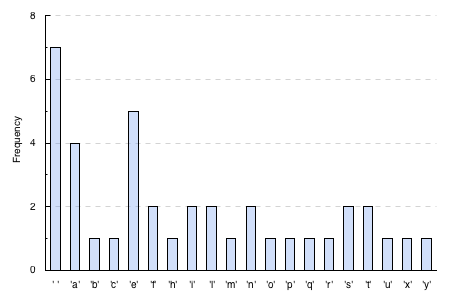

In [3]:
import Graphics.Rendering.Chart (layout_x_axis,laxis_generate,layout_y_axis
                                ,toRenderable,autoIndexAxis,laxis_title
                                ,layout_plots,plotBars,plot_bars_values
                                ,addIndexes,plot_bars_item_styles
                                ,fill_color)
import Data.Colour              (withOpacity)
import Data.Colour.Names        (cornflowerblue)
import Data.Default.Class       (def)
import Control.Lens             ((.~),_1)
import IHaskell.Display         (IHaskellDisplay(display))

instance Show a => IHaskellDisplay (Frequencies a) where
    display (Frequencies values)
        = display
        $ toRenderable
        $ layout_x_axis . laxis_generate .~ autoIndexAxis (map show (Map.keys values))
        $ layout_y_axis . laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes (map pure (Map.elems values))
                          $ plot_bars_item_styles . traverse . _1 . fill_color .~ cornflowerblue `withOpacity` 0.3
                          $ def ]
        $ def

:opt svg

frequencies "this is an example of a frequency table"

A Huffman tree:

In [4]:
:ext DeriveFoldable

import Data.Semigroup.Foldable (Foldable1(..))
import Data.Semigroup          (Semigroup(..))

data Tree a
    = Leaf { size :: {-# UNPACK #-} !Int, val :: a }
    | Node { size :: {-# UNPACK #-} !Int
           , lchild :: Tree a
           , rchild :: Tree a }
    deriving Foldable

instance Foldable1 Tree where
    foldMap1 f (Leaf _ x) = f x
    foldMap1 f (Node _ l r) = foldMap1 f l <> foldMap1 f r

And a way to display that

In [5]:
:ext FlexibleContexts

import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Tree

instance Show a => IHaskellDisplay (Tree a) where
    display = display . diagram . fblEx . toTree
      where
        toTree (Leaf i x) = Tree.Node (show i) [Tree.Node (show x) []]
        toTree (Node i l r) = Tree.Node (show i) [toTree l, toTree r]
        fblEx t' =
            renderTree 
                (\n -> text n # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white)
                (~~)
                (symmLayout t') # centerXY # pad 1.1

Building a tree is then easy:

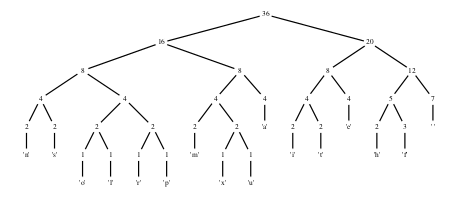

In [6]:
buildHuffman :: Heap (Tree a) -> Tree a
buildHuffman hp = case minView hp of
      (_,x,Nothing) -> x
      (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i+j) x y
        (j,y,Just ys) -> buildHuffman (insert (i+j) (Node (i+j) x y) ys)

fromFrequencies :: Frequencies a -> Heap (Tree a)
fromFrequencies (Frequencies freqs) = 
    case [ (i, Leaf i v) | (v,i) <- Map.toList freqs ] of
        [] -> error "fromFrequencies: Empty map"
        (x:xs) -> heapify (x :| xs)

huffmanTree :: Ord a => [a] -> Tree a
huffmanTree = buildHuffman . fromFrequencies . frequencies

huffmanTree "this is an example of a huffman tree"

Some ranges:

In [7]:
import IHaskell.Display    (IHaskellDisplay(display),latex,Display)
import Data.Semigroup      (Semigroup(..))
import Control.Applicative (liftA2)
import Text.Printf

data Range a
    = Range
    { lowerBound :: Maybe a
    , upperBound :: Maybe a
    } deriving (Eq,Ord)

instance (Ord a, PrintfArg a) => Show (Range a) where
    show (Range (Just l) (Just u))
      | l <= u = printf "[%v,%v)" l u
      | otherwise = printf ")%v,%v[" u l
    show (Range (Just l) Nothing) = printf "%v≤" l
    show (Range Nothing (Just u)) = printf "<%v" u
    show (Range Nothing Nothing) = "U"

instance (Ord a, PrintfArg a) => IHaskellDisplay (Range a) where
    display r = pure (Display [latex (lr r)])
      where
        lr (Range (Just l) (Just u))
          | l <= u = printf "$[%v,%v)$" l u
          | otherwise = printf "$)%v,%v[$" u l
        lr (Range (Just l) Nothing) = printf "$%v\\leq $" l
        lr (Range Nothing (Just u)) = printf "$<%v$" u
        lr (Range Nothing Nothing) = "$\\mathbb{U}$"

instance Ord a => Semigroup (Range a) where
    Range xl xu <> Range yl yu =
        Range
            (liftA2 min xl yl)
            (liftA2 max xu yu)

Range (Just 0) (Just 20) <> Range (Just 5) (Just 15)
Range (Just 0) Nothing   <> Range (Just 5) (Just 15)
Range (Just 10) (Just 5)

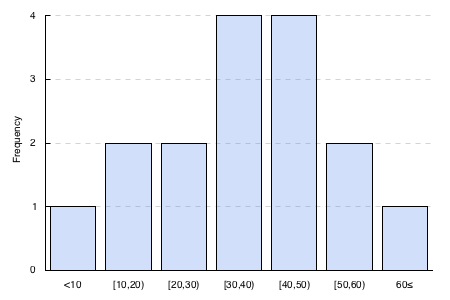

In [8]:
ages = Frequencies (Map.fromList
    [ (Range Nothing (Just 10)  , 1)
    , (Range (Just 10) (Just 20), 2)
    , (Range (Just 20) (Just 30), 2)
    , (Range (Just 30) (Just 40), 4)
    , (Range (Just 40) (Just 50), 4)
    , (Range (Just 50) (Just 60), 2)
    , (Range (Just 60) Nothing  , 1)
    ])

ages

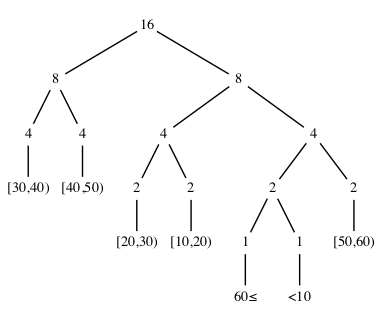

In [9]:
buildHuffman (fromFrequencies ages)

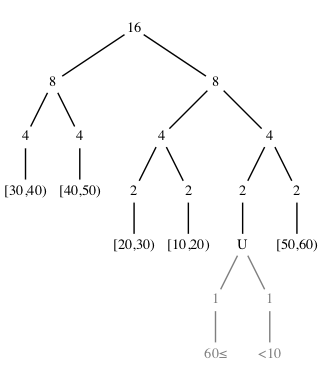

In [10]:
import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~),opacity,bg)
import           IHaskell.Display          (IHaskellDisplay(display)
                                           ,latex,Display(ManyDisplay))
import qualified Data.Tree                 as Tree
import           Data.Semigroup            (Semigroup(..))
import           Data.Semigroup.Foldable   (fold1)

data PrivateHuffman a
    = PrivateHuffman
    { kval :: Int
    , tree :: Tree a
    }

instance (Show a, Semigroup a) => IHaskellDisplay (PrivateHuffman a) where
    display (PrivateHuffman k tr) = 
        fmap (Display [ latex ("$k = " ++ show k ++ "$") ] <>)
                    ((display . diagram . bg white . fblEx . toTree) tr)
      where
        toTree (Leaf i x) =
            Tree.Node (i < k, show i) [Tree.Node (i < k, show x) []]
        toTree (Node i l r)
          | size l >= k && size r >= k =
               Tree.Node (i < k, show i) [toTree l, toTree r]
          | otherwise =
              Tree.Node (i < k, show i)
                  [ Tree.Node (i < k, show (fold1 l <> fold1 r))
                        [ toHiddenTree l, toHiddenTree r ] ]
                        
        toHiddenTree (Node i l r) =
            Tree.Node (True,show i)
                [toHiddenTree l, toHiddenTree r]
        toHiddenTree (Leaf i x) =
            Tree.Node (True,show i)
                [Tree.Node (True, show x) []]

        fblEx t' =
            renderTree'
                (\(b,n) -> text n # fontSizeL 0.2 # maybeOp b
                        <> circle 0.2 # fc white # lc white)
                (\((lb,_),ll) ((rb,_),rr) -> maybeOp (lb||rb) (ll ~~ rr))
                (symmLayout t') # centerXY # pad 1.1
        maybeOp False = id
        maybeOp True  = opacity 0.5

PrivateHuffman 2 (buildHuffman (fromFrequencies ages))

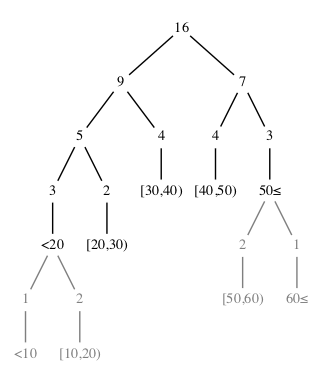

In [11]:
import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable      (Foldable(..))

buildAlphHuffman :: (Foldable f, Ord a) => f a -> Tree a
buildAlphHuffman xs = evalState (go c) (Map.toList (getFrequencies fs))
  where
    fs = frequencies xs
    c = length fs
    go n = do
      (x,i) <- gets head
      if i >= n
        then do
          modify tail
          pure (Leaf i x)
        else do
          let m = n `div` 2
          ls <- go m
          rs <- go (n - size ls)
          pure (Node (size ls + size rs) ls rs)

PrivateHuffman 2 (buildAlphHuffman ages)